<h1><center><br/>Analysis of the Million Song Dataset</center></h1>

<font size="3">
    <center>
        Jason D. Stock
        <br/>
        <i>April 13<sup>th</sup>, 2019</i>
        <br/>
        <br/>
        <i>Exploring Artist Demographics</i>
    </center>
</font>

---

## Overview

This notebook explores the demographics of artists by their locations to look at where songs are being produced throughout the years. Many artists in the [Million Song Dataset](https://labrosa.ee.columbia.edu/millionsong/) share the same coordinate locations, while others have details missing. Coordinate locations with multiple artists take the song the was most recently created as a statistic measure. Those that are missing information will be ignored.  

Apache Hadoop was used to group coordinate values by year, and remove invalid samples (those missing data).  Therefore, the data returned from the MapReduce job could easily be read into a Python DataFrame to compute visual analytics. The following imports were used for this notebook.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl

import seaborn as sns
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Sample Analysis

Foremost, the data has to acquired and read into Python. The first ten samples are shown below to give an idea for how the data is formatted. There are a total of 1907 rows in the data, with the three columns pertaining to longitude, latitude, and the most recent songs released by year. The years range from 1929 - 2010, but not every year is accounted for in the data.

In [2]:
data = pd.read_csv('location-year', sep='\t', names=['lon', 'lat', 'year']).astype(np.float)
data = data.iloc[1:]
print('There are {} samples'.format(data.shape[0]))
data.head(10)

There are 1907 samples


lon        lat    year
1    24.607500  56.875460  2010.0
2   -83.141540  42.865370  2010.0
3     3.895270   7.378840  2010.0
4    -1.343960  53.469690  2010.0
5     4.871370  50.456630  2010.0
6   -91.523820  30.974200  2010.0
7   -83.733597  42.328072  2010.0
8    16.938200  52.409000  2010.0
9     4.656500  51.811910  2010.0
10 -111.033180  45.679320  2010.0

The first ten samples all show the same year as 2010 which does not give good insight to how the samples are distributed. Therefore, the following histogram can be used to display proper distribution. It can be seen that the graph is skewed to the left with a mean less than that of the median by year. With a range spanning nearly 80 years, from 1929-2010, it is evident that the majority of locations with the latest artist releasing a song falls closer to the year 2000. This could be a bias to the data as a more and more recordings are sampled.

Year Statistics - mean: 1997, median 2001


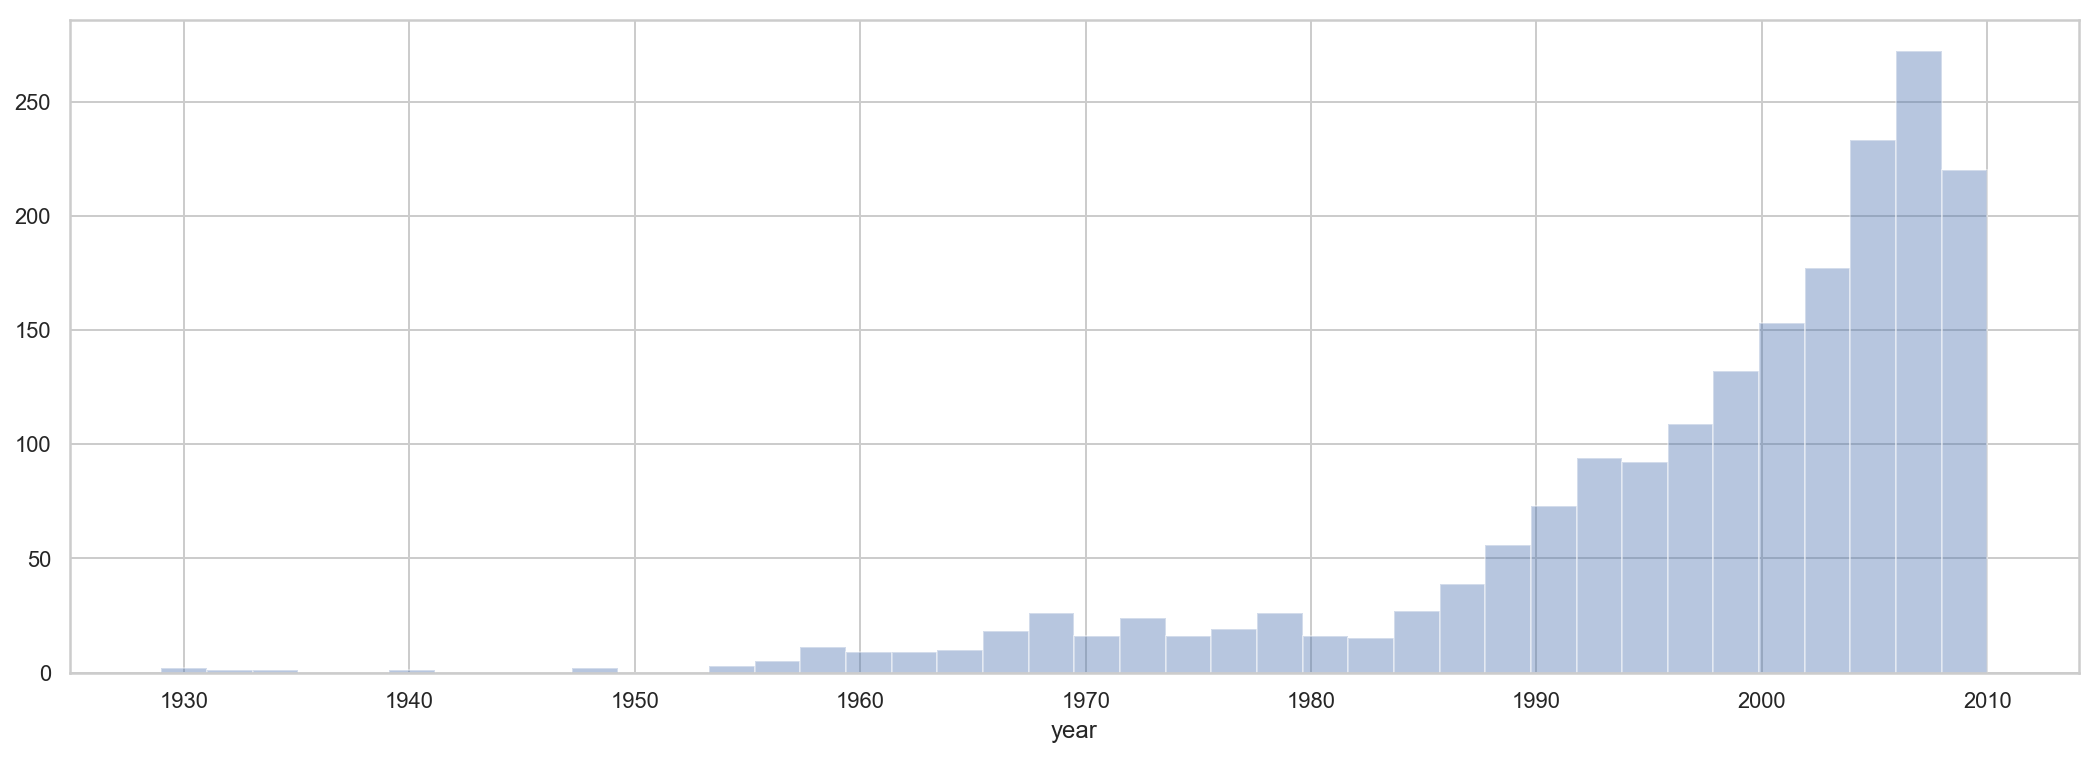

In [3]:
print('Year Statistics - mean: {0}, median {1}'.format(int(np.mean(data.year)),
                                                       int(np.median(data.year))))
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

sns.distplot(data.year, bins=40, kde=False);

## Visual Representation

Using this data, the coordinate locations will be overlaid on a map of the world differing by color to specify year. An image is easy to manipulate by location and channel in a multidimensional array. However, it is another challenge to transform the longitude and latitude coordinates to the related x / y coordinates of a flat two-dimensional map. A common projection of the world is the Mercator projection. This is a cylindrical map projection that has become the standard for nautical navigation. However, it is not the best representation for the true size of each country. This is because the latitude increases from the Equator to the poles, where the scale becomes infinite.  

A [sample projection](https://commons.wikimedia.org/wiki/File:Mercator_projection_SW.jpg) between between 82$^\circ$ S and 82$^\circ$ N has been provided from Wikimedia Commons to assist in this project. The image height and width are 1746 and 2058, respectively, with three channels in RGB for each pixel. 

The image can be read into a NumPy array and displayed with the functions `read_img` and `display` seen below. When reading in the image it is possible to convert the image to grayscale. This is done by converting the RGB channels to Luma by computing $Y = 0.2126 R + 0.7152 G + 0.0722 B$, but keeping a three-dimensional channel space - this is synonymous to the MATLAB function, `rgb2gray`.  

Let's read in this image and see how it looks in color to understand why it should be converted to grayscale!

The image shape has height of 1746, width of 2058 and 3 channels


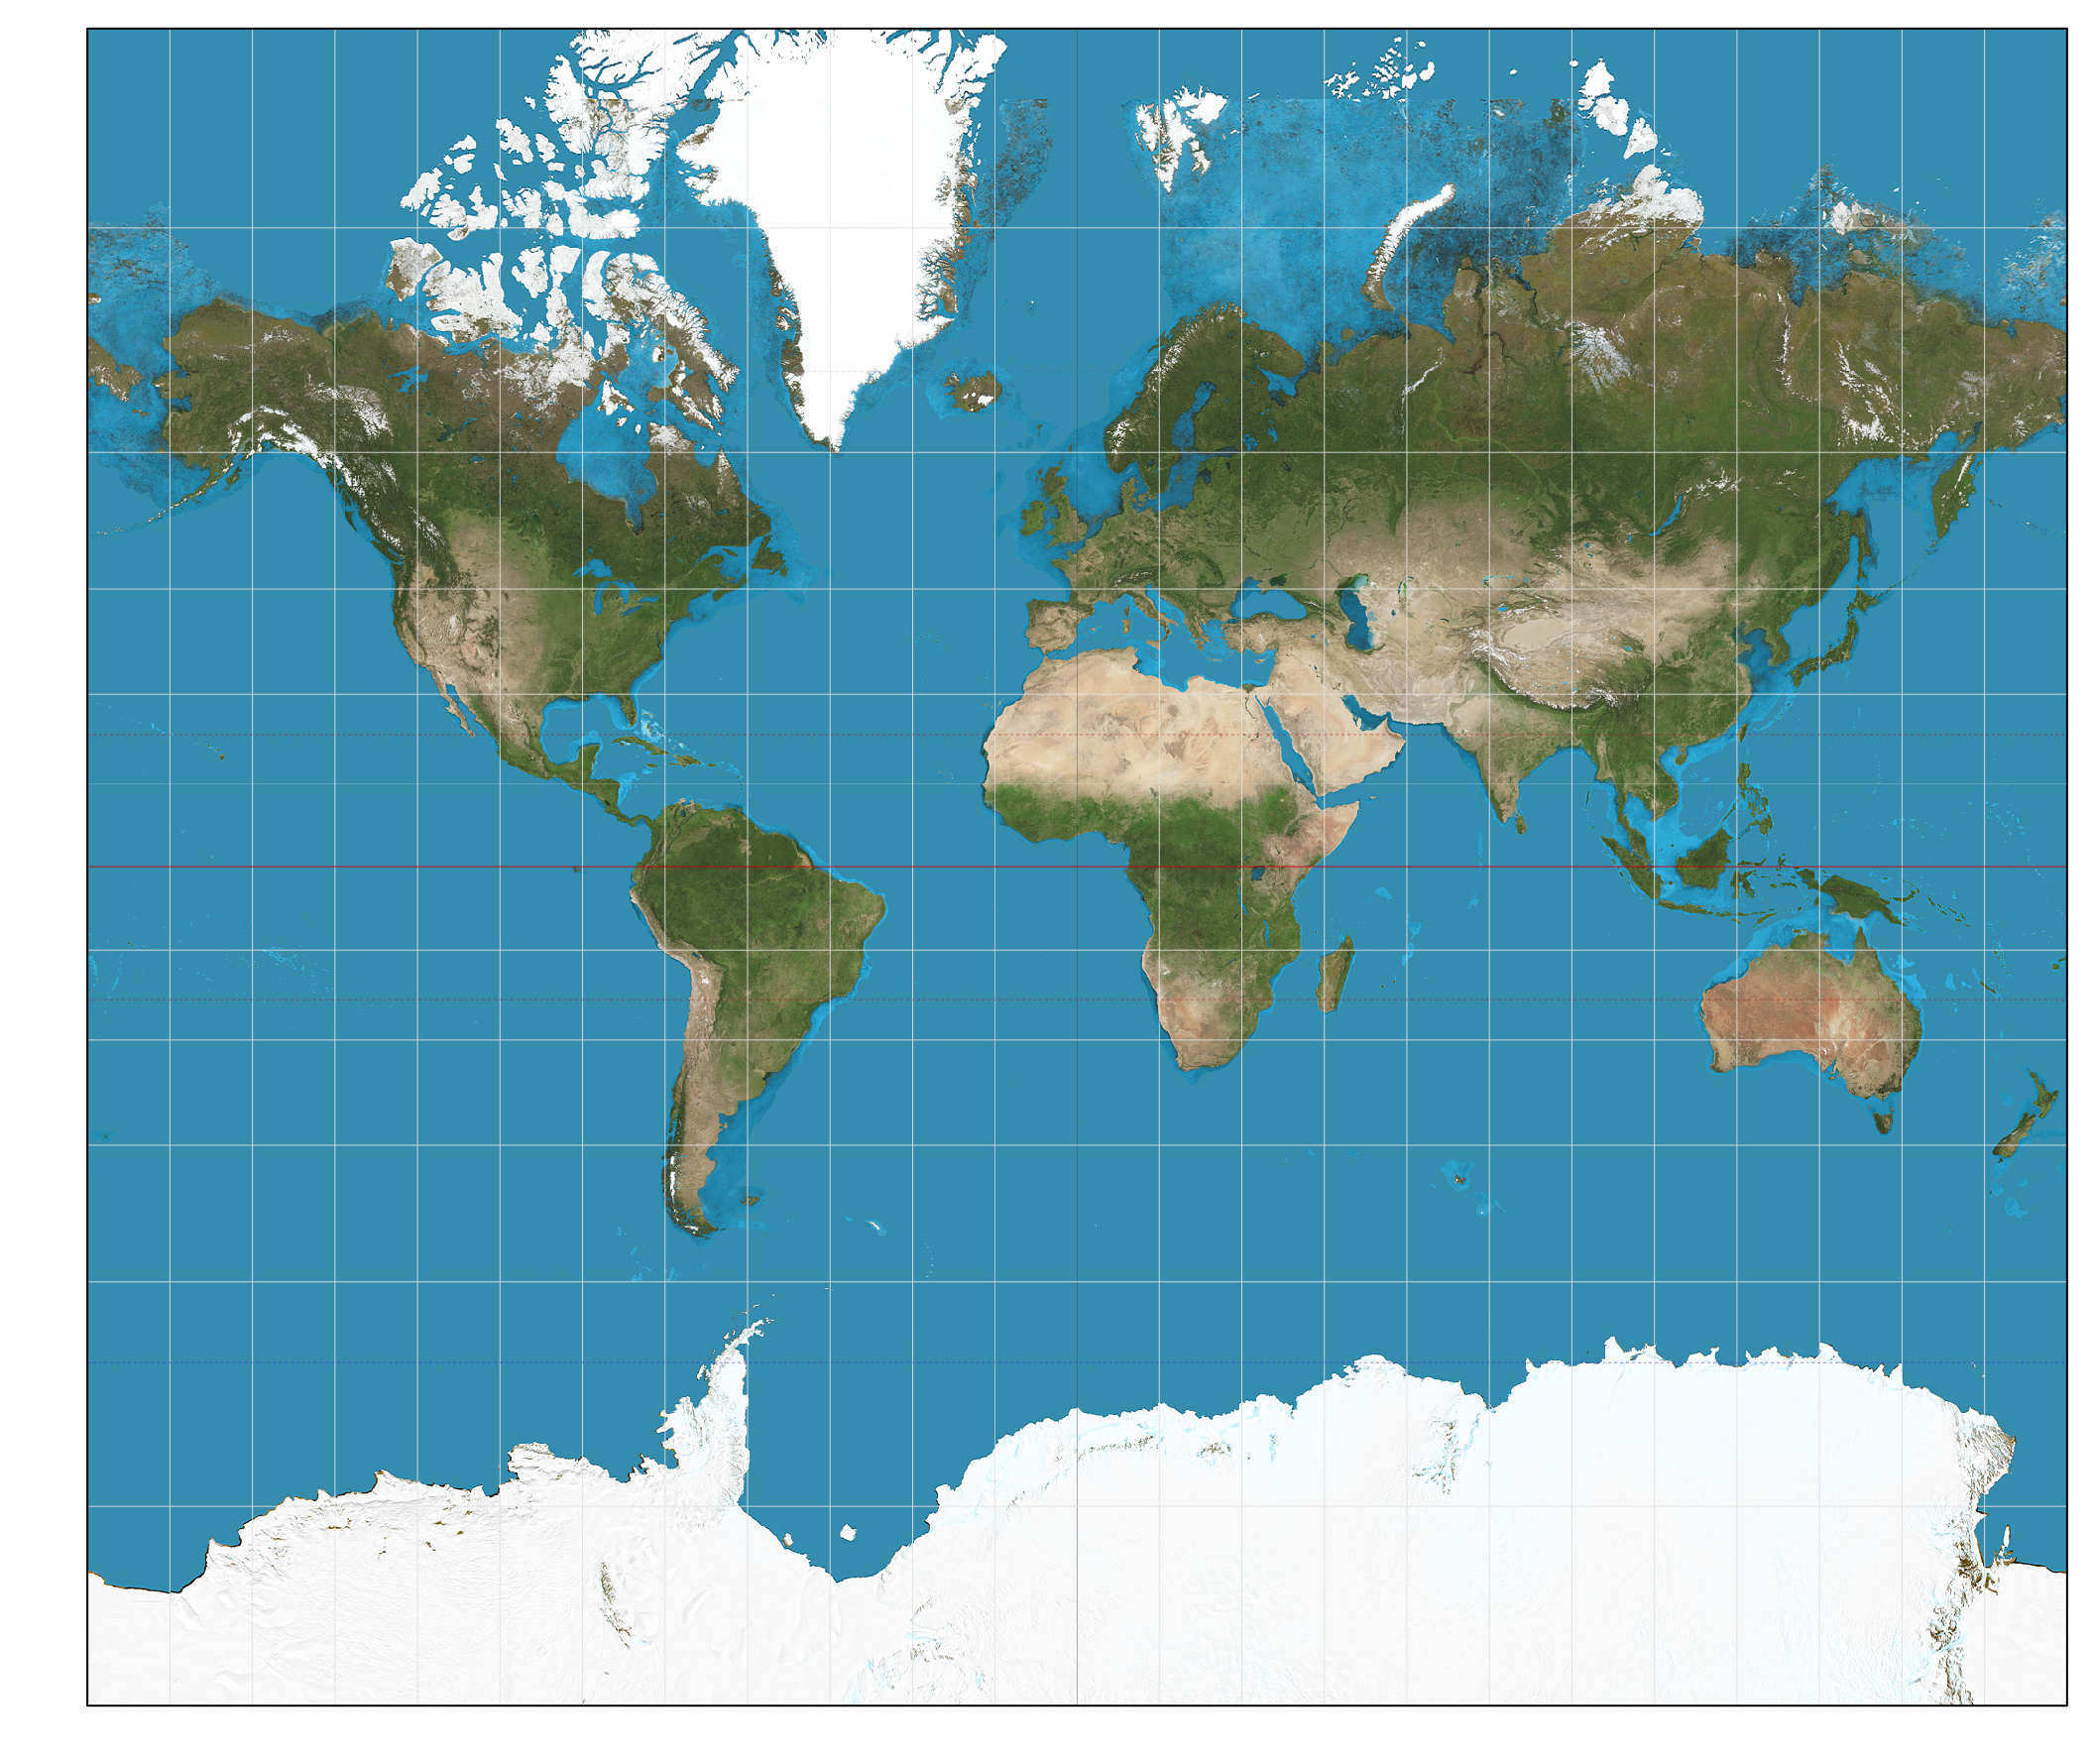

In [4]:
def read_img(path, color=False):
    img = mpimg.imread(path).copy()
    if not color:
        dot = img[..., :3] @ [0.2126 , 0.7152, 0.0722]
        dot[dot > 242] = 242
        s = img.shape
        for i in range(s[0]):
            for j in range(s[1]):
                img[i, j, ...] = [dot[i][j]]*3
    return img

def display(img):
    plt.figure(figsize=(18,18))
    plt.imshow(img)
    plt.axis('off')
    
img = read_img('mercator_proj.jpg', color=True)
shape = img.shape
print('The image shape has height of {0}, width of {1} and {2} channels'
      .format(shape[0], shape[1], shape[2]))
display(img)

### Derivation of the Mercator Projection

Now that we have an image with corresponding height and width measures, we can actually convert the longitude and latitude values from the globe to x / y coordinates. This can be derived following a variation of the derivation seen on the Mercator projection [wiki page](https://en.wikipedia.org/wiki/Mercator_projection).  

Rather than use the radius of the earth, we can use the width of our map, and find a relative radius $R$.

$$
W = 2 \pi R \implies R = \frac{W}{2 \pi}
$$

Let the geographical longitude be represented by $\lambda$, and $\varphi$ for that of latitude. We can use $R$, and elementary methods to derive an expression for $y$.

$$
\begin{align*}
y &= \frac{R}{2} \ln \left ( \frac {1 + \sin {\varphi}}{1 - \sin{\varphi}} \right ) \\
&= R \ln \left ( \frac {1 + \sin {\varphi}}{\cos{\varphi}} \right ) \\
&= R \ln ( \sec{\varphi} + \tan{\varphi} ) \\
&= R \tanh^{-1}(\sin{\varphi}) \\
&= R \tanh^{-1}\left (\sin{\frac{\pi \varphi^{\circ}}{180}} \right)
\end{align*}
$$

Finding $x$ with $\lambda$ is easier since it accounts for the map coordinates as a relative ratio to $R$.  
This is seen as,

$$
x = \frac{\pi R (\lambda^{\circ} - \lambda_0^{\circ})}{180}
$$

Both of the above equations for $x$ and $y$ are written to transform the initial $\lambda$ and $\varphi$ values from geographical degrees to radians. Lastly, since the map is cropped between 82$^\circ$ S and 82$^\circ$ N, we will have to take an offset as $y_{\text{offset}}$ from the bottom of the map to account for the missing distance in the equation for $y$. The value for $y_{\text{offset}}$ is found in the same manner as $y$, and can be subtracted from the calculated value for $y$.  

The function `mercator_transform` transforms $\lambda$ and $\varphi$ to the respective $x$ and $y$ coordinates. This will be helpful for iterating over our data and plotting the results. Let's do a quick test!  The island of Hawaii can be found at 155.6659$^\circ$ W 19.5429$^\circ$ N, a conversion show $x = 139, y = 760$. Hawaii is near the Equator, but slightly above, and all the way to the left. This makes sense relative to the height and width of the map.

In [5]:
width = 2058
height = 1746

lon_left = -180
lon_right = 180

lat_bottom = -82
lat_bottom_rad = lat_bottom * np.pi / 180

R = width / (2 * np.pi)
y_offset = R * np.arctanh(np.sin(lat_bottom_rad))

def mercator_transform(lon, lat):
    x = (np.pi * R * (lon - lon_left) ) / 180
    
    lat_rad = lat * np.pi / 180
    y = height - ((R * np.arctanh(np.sin(lat_rad))) - y_offset);

    return int(x), int(y);

mercator_transform(-155.6659, 19.5429)

(139, 760)

### Displaying Data

For each sample in the data, a point will be drawn at the pixel location computed by `mercator_transform`. This is done by changing the luma value to RGB once again. To expand the distance of the point, the surrounding pixels following $ (x - a)^2 + (y - b)^2 = r^2 + 1 $ will be filled in. At this time, the geographical coordinates can be converted to corresponding $x$ and $y$ values and displayed on the map, but what does this have to do with the year?  

A color is assigned to the range of years in the data where the oldest year of 1929 is represented by blue, and the most recent year of 2010 as red. This gives an indication to where artists are located and the from what time their most recent music is made. 

In [6]:
year_range = (data['year'].max(), data['year'].min())
diff = int((year_range[0] - year_range[1]) / 4)

def color(year):
    sub = int(((year - year_range[1]) / (year_range[0] - year_range[1])) * 255 * 4) % 255

    if year <= year_range[1] + diff: 
        return (0, sub, 255) # -> blue
    
    elif year <= year_range[1] + diff * 2: 
        return (0, 255, 255 - sub) # -> green
    
    elif year <= year_range[1] + diff * 3:
        return (sub, 255, 0) # -> yellow
    
    else: 
        return (255, 255 - sub , 0) # -> red

def draw_point(img, p, freq, r=2):
    rows, cols = [ list(range(p[i]-r, p[i]+r+1)) for i in range(2)]
    for x in rows:
        for y in cols:
            if (x - p[0])**2 + (y - p[1])**2 <= r * r + 1:
                img[y, x, ...] = color(freq)
                
def show(data, img):
    for i in range(data.shape[0]):
        d = data.iloc[i]
        lon, lat, year = d['lon'], d['lat'], d['year']

        pos = mercator_transform(lon, lat)
        draw_point(img, pos, year, r=2)
        
    display(img) 
    fig, ax = plt.subplots(figsize=(18, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = mpl.colors.Normalize(vmin=year_range[1], vmax=year_range[0])

    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=mpl.cm.jet,
                                    norm=norm,
                                    orientation='horizontal')
    cb1.set_label('Year Range')

We can make use of all the above functions and the data by using the three following lines of code. This will read in the image to a NumPy array, and then show the data by *drawing* over the image, and then saving the updated array to disk.

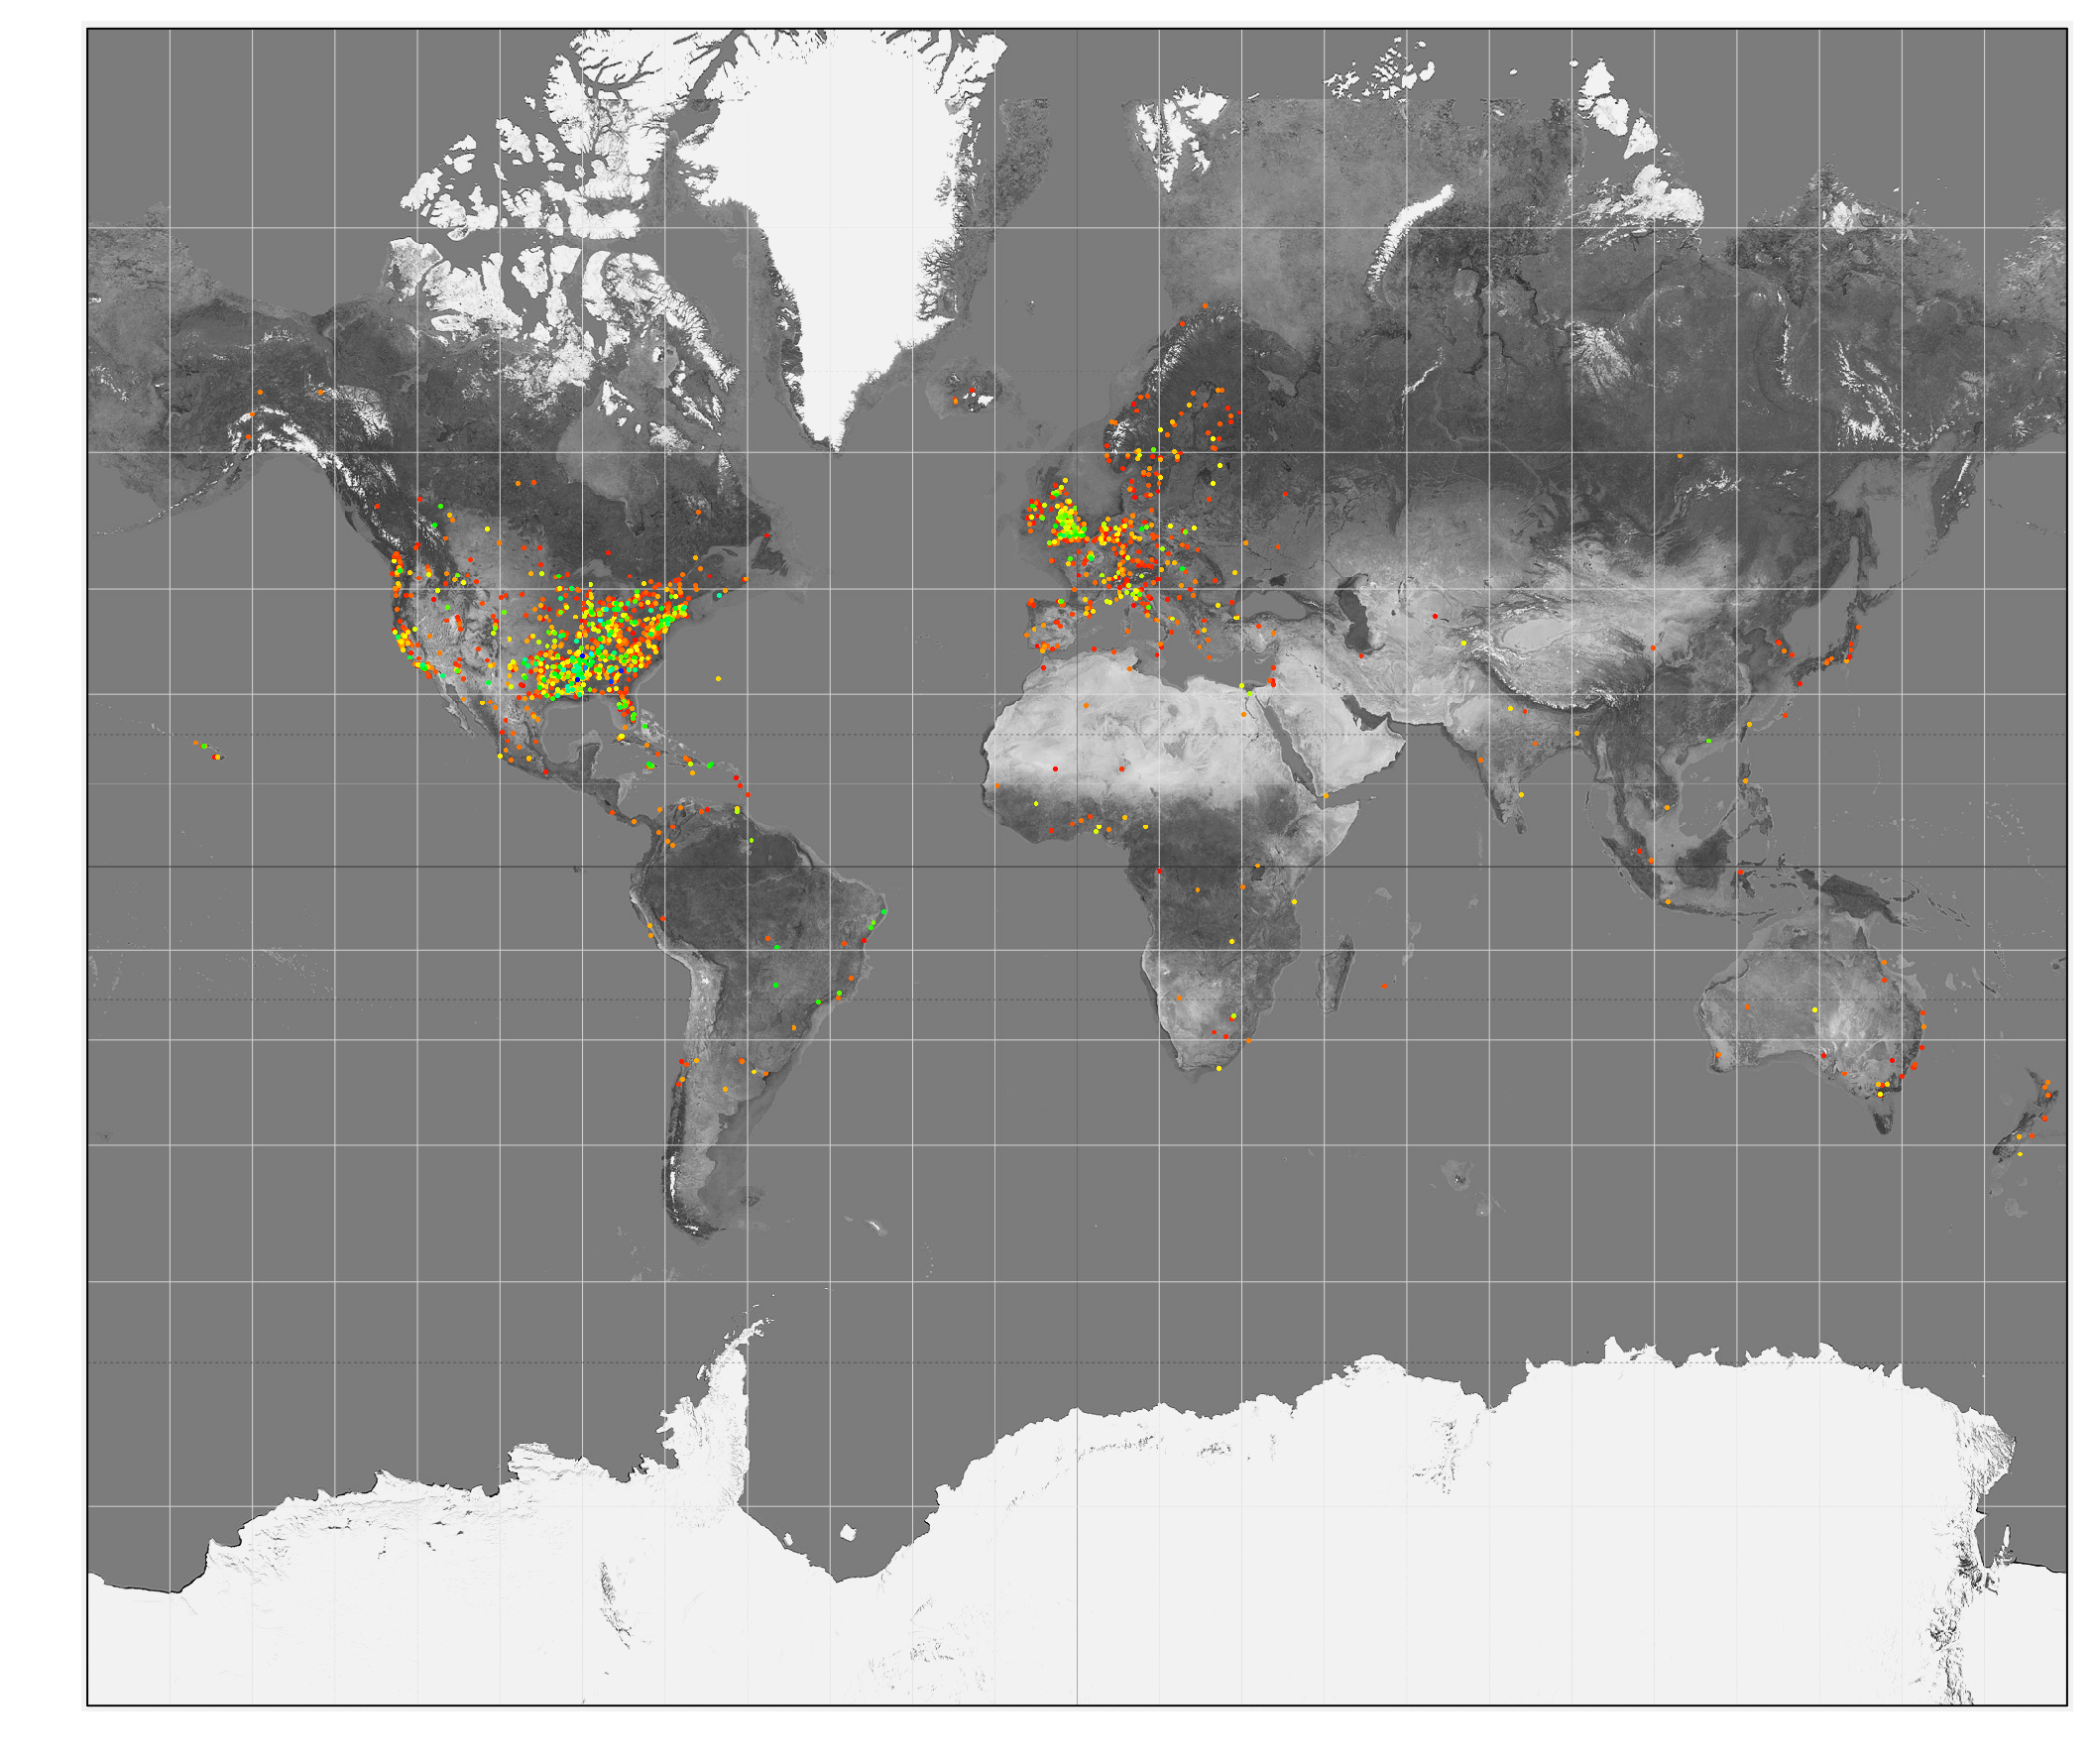

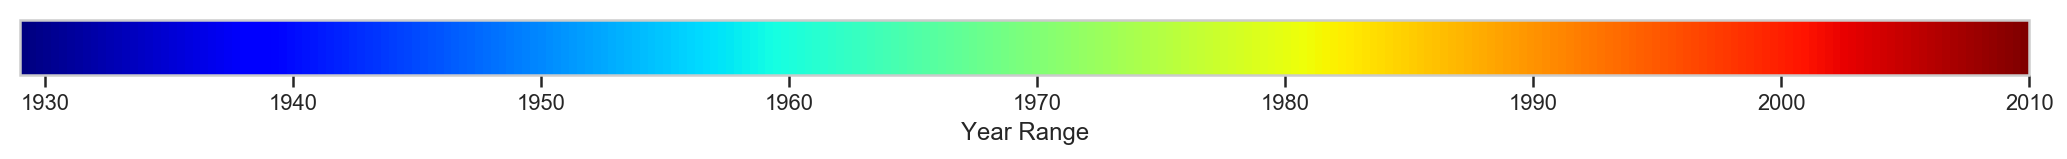

In [7]:
img = read_img('mercator_proj.jpg')

show(data, img)

mpimg.imsave('rendered-locations.png', img)

The image above follows the histogram of the years quite closely with the majority of geographical coordinates representing the years around 2000. This can be seen with the red points on the map. The few samples from the blue end of the spectrum can be seen in North America in the South-East region. Most interesting, are the locations of music from around 1970 in large clusters, centering around the center of the city - especially in the United Kingdom. Expanding outwards from here are many samples from the later parts of the century. Japan, New Zealand, and Australia show to have the most recent music coming from around 1990 - 2010.  

Overall, the map shows to have two large clusters around Europe and the United States. This could be a bias of the Million Song Dataset, or subject to taking the most recent song from a given location. Either way it is evident that the majority of the music from the late 20$^\text{th}$ Century came from the United Kingdom and the United States.  

---